**This is still a WIP**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from params import JumpDiffusionParams
from dataclasses import dataclass
from typing import Optional, Callable, Dict, Any, Tuple
from log_health import HealthProcessParameters, LogHealthProcess

# ----------------------------------------------------
# 1. Model & strategy classes 
# ----------------------------------------------------

@dataclass
class JumpDiffusionParams:
    mu: float
    sigma: float
    lam: float
    delta: float
    eta: float
    rho: float = 0.0

@dataclass
class HealthProcessParameters:
    w_X: float
    w_Y: float
    b_X: float
    mu_X: float
    mu_Y: float
    sigma_X: float
    sigma_Y: float
    rho: float
    lambda_X: float
    lambda_Y: float
    delta_X: float
    delta_Y: float
    eta_X: float
    eta_Y: float
    X0: float
    Y0: float

In [11]:
class LogHealthProcess:
    def __init__(self, p: HealthProcessParameters):
        self.p = p

    def drift_diffusion(self) -> float:
        """Drift of log(X/Y) from diffusion only (Itô adjustment included)."""
        p = self.p
        return (p.mu_X - p.mu_Y
                - 0.5 * (p.sigma_X**2 + p.sigma_Y**2 - 2 * p.rho * p.sigma_X * p.sigma_Y))

    def mgf_jump_X(self, theta: float) -> float:
        """MGF of one-sided downward jump U_X = -(δ_X + Exp(η_X))."""
        p = self.p
        if theta <= -p.eta_X:
            raise ValueError(f"theta={theta} must be > -{p.eta_X} for mgf_jump_X")
        log_exp_term = -theta * p.delta_X
        log_ratio = np.log(p.eta_X) - np.log(p.eta_X + theta)
        return np.exp(log_exp_term + log_ratio)

    def mgf_jump_Y(self, theta: float) -> float:
        """MGF of one-sided upward jump U_Y = +(δ_Y + Exp(η_Y))."""
        p = self.p
        if theta >= p.eta_Y:
            raise ValueError(f"theta={theta} must be < {p.eta_Y} for mgf_jump_Y")
        log_exp_term = theta * p.delta_Y
        log_ratio = np.log(p.eta_Y) - np.log(p.eta_Y - theta)
        return np.exp(log_exp_term + log_ratio)

    def psi_h(self, theta: float) -> float:
        """
        Lévy exponent of log-health increments.

        Formula: ψ_h(θ) = θ·drift_diffusion
                        + ½θ²·variance_diffusion
                        + λ_X(MGF_X(θ) - 1)
                        + λ_Y(MGF_Y(-θ) - 1)

        Valid for -η_X < θ < η_Y. Note the sign flip (-θ) for the Y jump MGF
        due to the ratio structure in h(t) = log(X/Y).

        Args:
            theta: Moment parameter, must satisfy -η_X < θ < η_Y

        Returns:
            Lévy exponent value

        Raises:
            ValueError: If theta is outside the valid domain
        """
        p = self.p

        # Validate theta is in valid domain
        lower_bound = -p.eta_X
        upper_bound = p.eta_Y

        if not (lower_bound < theta < upper_bound):
            raise ValueError(
                f"theta={theta} outside valid domain "
                f"({lower_bound}, {upper_bound}). "
                f"Valid range: -η_X < θ < η_Y where "
                f"η_X={p.eta_X}, η_Y={p.eta_Y}"
            )

        diff = (theta * self.drift_diffusion()
                + 0.5 * (theta**2) * self.variance_diffusion)

        jumps_X = p.lambda_X * (self.mgf_jump_X(theta) - 1.0)
        jumps_Y = p.lambda_Y * (self.mgf_jump_Y(-theta) - 1.0)

        return diff + jumps_X + jumps_Y

    @property
    def variance_diffusion(self) -> float:
        """
        Approx diffusion variance of log-health
        """
        sig2_h = self.p.sigma_X**2 + self.p.sigma_Y**2 - 2*self.p.rho*self.p.sigma_X*self.p.sigma_Y
        return sig2_h * self.p.b_X**2

    def h0(self) -> float:
        """
        Initial log-health: h = log(b_X * w_X * X0 / (w_Y * Y0))
        """
        return np.log(self.p.b_X * self.p.w_X * self.p.X0 / (self.p.w_Y * self.p.Y0))


In [12]:

# =====================================================
# MLE on USDT (X) and ETH (Y)
# =====================================================

import os
import sys

# Use absolute path to data
data_base = "/Users/tedig/Defi_interestRate-1/data/raw/coins_prices"
usdt_file = os.path.join(data_base, "USDT_All_graph_coinmarketcap.csv")
eth_file = os.path.join(data_base, "ETH_All_graph_coinmarketcap.csv")

print(f"Loading USDT from: {usdt_file}")
print(f"Loading ETH from: {eth_file}")

x_df = pd.read_csv(usdt_file, sep=';')
y_df = pd.read_csv(eth_file, sep=';')

print("\nUSDT data shape:", x_df.shape)
print("ETH data shape:", y_df.shape)

# Extract close prices
usdt_close = pd.to_numeric(x_df['close'], errors='coerce').dropna().values
eth_close = pd.to_numeric(y_df['close'], errors='coerce').dropna().values
print(f"\nAfter parsing:")
print(f"USDT close prices: {len(usdt_close)} values, last={usdt_close[-1]:.4f}")
print(f"ETH close prices: {len(eth_close)} values, last={eth_close[-1]:.2f}")

# Compute log-returns
x_log_returns = np.diff(np.log(usdt_close))
y_log_returns = np.diff(np.log(eth_close))

print(f"\nUSDT log-returns: {len(x_log_returns)} observations")
print(f"  mean={x_log_returns.mean():.6f}, std={x_log_returns.std():.6f}")
print(f"  min={x_log_returns.min():.6f}, max={x_log_returns.max():.6f}")
print(f"\nETH log-returns: {len(y_log_returns)} observations")
print(f"  mean={y_log_returns.mean():.6f}, std={y_log_returns.std():.6f}")
print(f"  min={y_log_returns.min():.6f}, max={y_log_returns.max():.6f}")

Loading USDT from: /Users/tedig/Defi_interestRate-1/data/raw/coins_prices/USDT_All_graph_coinmarketcap.csv
Loading ETH from: /Users/tedig/Defi_interestRate-1/data/raw/coins_prices/ETH_All_graph_coinmarketcap.csv

USDT data shape: (118, 8)
ETH data shape: (112, 8)

After parsing:
USDT close prices: 118 values, last=0.9996
ETH close prices: 112 values, last=3947.29

USDT log-returns: 117 observations
  mean=-0.000004, std=0.015754
  min=-0.075968, max=0.100865

ETH log-returns: 111 observations
  mean=0.077331, std=0.326957
  min=-0.768767, max=1.151671


In [13]:
# Import JumpDiffusionParams from params module
from params import JumpDiffusionParams as JPDParams

# Initialize USDT params and calibrate
print("\n" + "="*70)
print("CALIBRATING USDT (X, Long Asset) via MLE")
print("="*70)
xparams_mle = JPDParams(mu=0.0, sigma=0.01, lam=0.01, delta=0.01, eta=1.0, rho=0.0)
xparams_mle.fit_mle(x_log_returns, dt=1/365, verbose=True)

# Initialize ETH params and calibrate
print("\n" + "="*70)
print("CALIBRATING ETH (Y, Short Asset) via MLE")
print("="*70)
yparams_mle = JPDParams(mu=0.0, sigma=0.1, lam=0.05, delta=0.05, eta=1.0, rho=0.0)
yparams_mle.fit_mle(y_log_returns, dt=1/365, verbose=True)


CALIBRATING USDT (X, Long Asset) via MLE
  Initial params: mu=-0.001304, sigma=0.302279, lam=0.341880, delta=0.020000, eta=2.000000
  ✓ MLE converged (nfev=228, nll=-374.6879)
    mu=0.048579, sigma=0.070338, lam=1.000000, delta=0.000000, eta=0.500000

CALIBRATING ETH (Y, Short Asset) via MLE
  Initial params: mu=0.500000, sigma=2.000000, lam=0.500000, delta=0.020000, eta=2.000000
  ✓ MLE converged (nfev=12, nll=316.8867)
    mu=0.500000, sigma=2.000000, lam=1.000000, delta=0.000000, eta=0.500000


In [14]:
# Must decide on a rule for asset selection (for all strats)
# USDC seems best(safest) idea for the paper
# Other SCs might be considered too 
# Tether is popular but risky - failed audit recently

@dataclass
class StablecoinShortParams:
    """Parameters for stablecoin-short strategy - inherited from the MLE calibration."""
    W0: float = 10_000.0
    T: float = 30 / 365.0  # horizon in years
    r_X: float = 0.04
    r_Y: float = 0.08
    b_X: float = 0.8
    X0: float = 1.0
    Y0: float = 1.0
    fht_func: Optional[Callable[..., float]] = None

    # Jump-diffusion parameters
    X_params: JumpDiffusionParams = None
    Y_params: JumpDiffusionParams = None

    def __post_init__(self):
        if self.W0 <= 0:
            raise ValueError("W0 must be positive")
        if self.T <= 0:
            raise ValueError("T must be positive")
        if not (0 < self.b_X <= 1):
            raise ValueError("b_X must be in (0,1]")
        if self.X0 <= 0 or self.Y0 <= 0:
            raise ValueError("Initial prices must be positive")
        if self.X_params is None or self.Y_params is None:
            raise ValueError("X_params and Y_params must be provided")


class StablecoinShortStrategy:
    """Stablecoin short strategy using log-health from JumpDiffusion processes."""

    def __init__(self, params: StablecoinShortParams):
        self.p = params
        # Build log-health process (h = log(b_X * w_X * X / (w_Y * Y)))
        self.health_process = LogHealthProcess(
            HealthProcessParameters(
                # placeholders; updated from weights_from_r before use
                w_X=1.00000001,
                w_Y=0.00000001,
                b_X=self.p.b_X,
                mu_X=self.p.X_params.mu,
                mu_Y=self.p.Y_params.mu,
                sigma_X=self.p.X_params.sigma,
                sigma_Y=self.p.Y_params.sigma,
                rho=self.p.X_params.rho,
                lambda_X=self.p.X_params.lam,
                lambda_Y=self.p.Y_params.lam,
                delta_X=self.p.X_params.delta,
                delta_Y=self.p.Y_params.delta,
                eta_X=self.p.X_params.eta,
                eta_Y=self.p.Y_params.eta,
                X0=self.p.X0,
                Y0=self.p.Y0
            )
        )

    def psi_h(self, theta: float) -> float:
        """Forward psi_h to the internal health process."""
        return self.health_process.psi_h(theta)

    # ---------------------------
    # Weight mapping: r -> (w_X, w_Y)
    # ---------------------------
    def weights_from_r(self, r: float) -> Tuple[float, float]:
        if r <= 0:
            raise ValueError("Allocation r must be positive")
        w_X = float(r)
        w_Y = r - 1.0
        return w_X, w_Y

    # ---------------------------
    # Expected wealth & variance
    # ---------------------------
    def expected_wealth(self, r: float) -> float:
        w_X, w_Y = self.weights_from_r(r)
        # update health process weights
        self.health_process.p.w_X = w_X
        self.health_process.p.w_Y = w_Y

        # carry component
        carry_ann = w_X * self.p.r_X - w_Y * self.p.r_Y
        carry_return = carry_ann * self.p.T

        # price component via log-health Lévy exponents
        # Use smaller theta values that fit within (-η_X, η_Y) domain
        price_return = 0.0
        try:
            # Try to use moderate theta values for moments
            eta_X = self.health_process.p.eta_X
            eta_Y = self.health_process.p.eta_Y
            # Pick theta values safely within the domain
            theta_pos = min(0.5, eta_Y * 0.9)  # stay well within upper bound
            theta_neg = max(-0.5, -eta_X * 0.9)  # stay well within lower bound
            
            E_X = np.exp(self.health_process.psi_h(theta_pos)) - 1.0
            E_Y = np.exp(self.health_process.psi_h(theta_neg)) - 1.0
            price_return = w_X * E_X - w_Y * E_Y
        except ValueError:
            # If theta domain is too narrow, skip price component
            price_return = 0.0

        return self.p.W0 * (1.0 + carry_return + price_return)

    def wealth_variance(self, r: float) -> float:
        w_X, w_Y = self.weights_from_r(r)
        self.health_process.p.w_X = w_X
        self.health_process.p.w_Y = w_Y

        var_h = self.health_process.variance_diffusion  # approximate diffusion variance
        return (w_X ** 2 + w_Y ** 2) * self.p.W0 ** 2 * var_h

    # ---------------------------
    # Log-health & liquidation
    # ---------------------------
    def h0(self, r: float) -> float:
        w_X, w_Y = self.weights_from_r(r)
        self.health_process.p.w_X = w_X
        self.health_process.p.w_Y = w_Y
        return self.health_process.h0()

    def liquidation_probability(self, r: float) -> Optional[float]:
        if self.p.fht_func is None:
            return None
        h0_val = self.h0(r)
        return self.p.fht_func(h0_val, self.health_process.psi_h, self.p.T)

    # ---------------------------
    # Utility function
    # ---------------------------
    def utility(self, r: float, rho1: float = 1.0, rho2: float = 1.0) -> Dict[str, Any]:
        meanW = self.expected_wealth(r)
        varW = self.wealth_variance(r)
        p_liq = self.liquidation_probability(r)

        if p_liq is None:
            U = meanW - rho1 * varW
        else:
            U = meanW - rho1 * varW - rho2 * p_liq

        return {
            "r": r,
            "U": U,
            "meanW": meanW,
            "varW": varW,
            "p_liq": p_liq
        }


def create_stablecoin_short_strategy(
    W0: float = 10_000.0,
    days: int = 30,
    r_X: float = 0.04,
    r_Y: float = 0.08,
    b_X: float = 0.8,
    X0: float = 1.0,
    Y0: float = 1.0,
    X_params: JumpDiffusionParams = None,
    Y_params: JumpDiffusionParams = None,
    fht_func: Optional[Callable[..., float]] = None
) -> StablecoinShortStrategy:
    params = StablecoinShortParams(
        W0=W0,
        T=days / 365.0,
        r_X=r_X,
        r_Y=r_Y,
        b_X=b_X,
        X0=X0,
        Y0=Y0,
        X_params=X_params,
        Y_params=Y_params,
        fht_func=fht_func
    )
    return StablecoinShortStrategy(params)

In [15]:

# Create strategy with calibrated parameters
print("\n" + "="*70)
print("CREATING STRATEGY WITH CALIBRATED PARAMETERS")
print("="*70)
strategy_calibrated = create_stablecoin_short_strategy(
    W0=10_000.0,
    days=30,
    r_X=0.04,  # USDT funding rate over past n days
    r_Y=0.08,  # ETH funding rate 
    b_X=0.8,
    X0=usdt_close[-1],  # Use last USDT price
    Y0=eth_close[-1],   # Use last ETH price
    X_params=xparams_mle,
    Y_params=yparams_mle,
    fht_func=None
)

print(f"\n✓ Strategy created successfully!")
print(f"  USDT initial price (X0): {usdt_close[-1]:.4f}")
print(f"  ETH initial price (Y0): {eth_close[-1]:.2f}")
print(f"\n  Calibrated Parameters:")
print(f"    USDT (X): mu={xparams_mle.mu:.6f}, sigma={xparams_mle.sigma:.6f}, " +
      f"lam={xparams_mle.lam:.6f}, delta={xparams_mle.delta:.6f}, eta={xparams_mle.eta:.6f}")
print(f"    ETH (Y):  mu={yparams_mle.mu:.6f}, sigma={yparams_mle.sigma:.6f}, " +
      f"lam={yparams_mle.lam:.6f}, delta={yparams_mle.delta:.6f}, eta={yparams_mle.eta:.6f}")


CREATING STRATEGY WITH CALIBRATED PARAMETERS

✓ Strategy created successfully!
  USDT initial price (X0): 0.9996
  ETH initial price (Y0): 3947.29

  Calibrated Parameters:
    USDT (X): mu=0.048579, sigma=0.070338, lam=1.000000, delta=0.000000, eta=0.500000
    ETH (Y):  mu=0.500000, sigma=2.000000, lam=1.000000, delta=0.000000, eta=0.500000


In [16]:

# ----------------------------------------------------
# Set up a baseline model instance
# ----------------------------------------------------

X_params = JumpDiffusionParams(
    mu=0.02,    # collateral drift
    sigma=0.25, # collateral vol
    lam=0.1,    # jump intensity
    delta=-0.15,
    eta=0.30,
    rho=0.0
)

Y_params = JumpDiffusionParams(
    mu=0.001,   # stablecoin drift
    sigma=0.02, # stablecoin vol
    lam=0.05,
    delta=-0.01,
    eta=0.05,
    rho=0.0
)

strategy = create_stablecoin_short_strategy(
    W0=10_000.0,
    days=30,
    r_X=0.04,
    r_Y=0.08,
    b_X=0.8,
    X0=1.0,
    Y0=1.0,
    X_params=X_params,
    Y_params=Y_params,
    fht_func=None   # plug your FHT function here !!!!!!
)

print("Strategy object created.")

Strategy object created.


Optimal r*: 0.500
Expected wealth: 10049.32
Variance: 2012800.00
P(liq): None


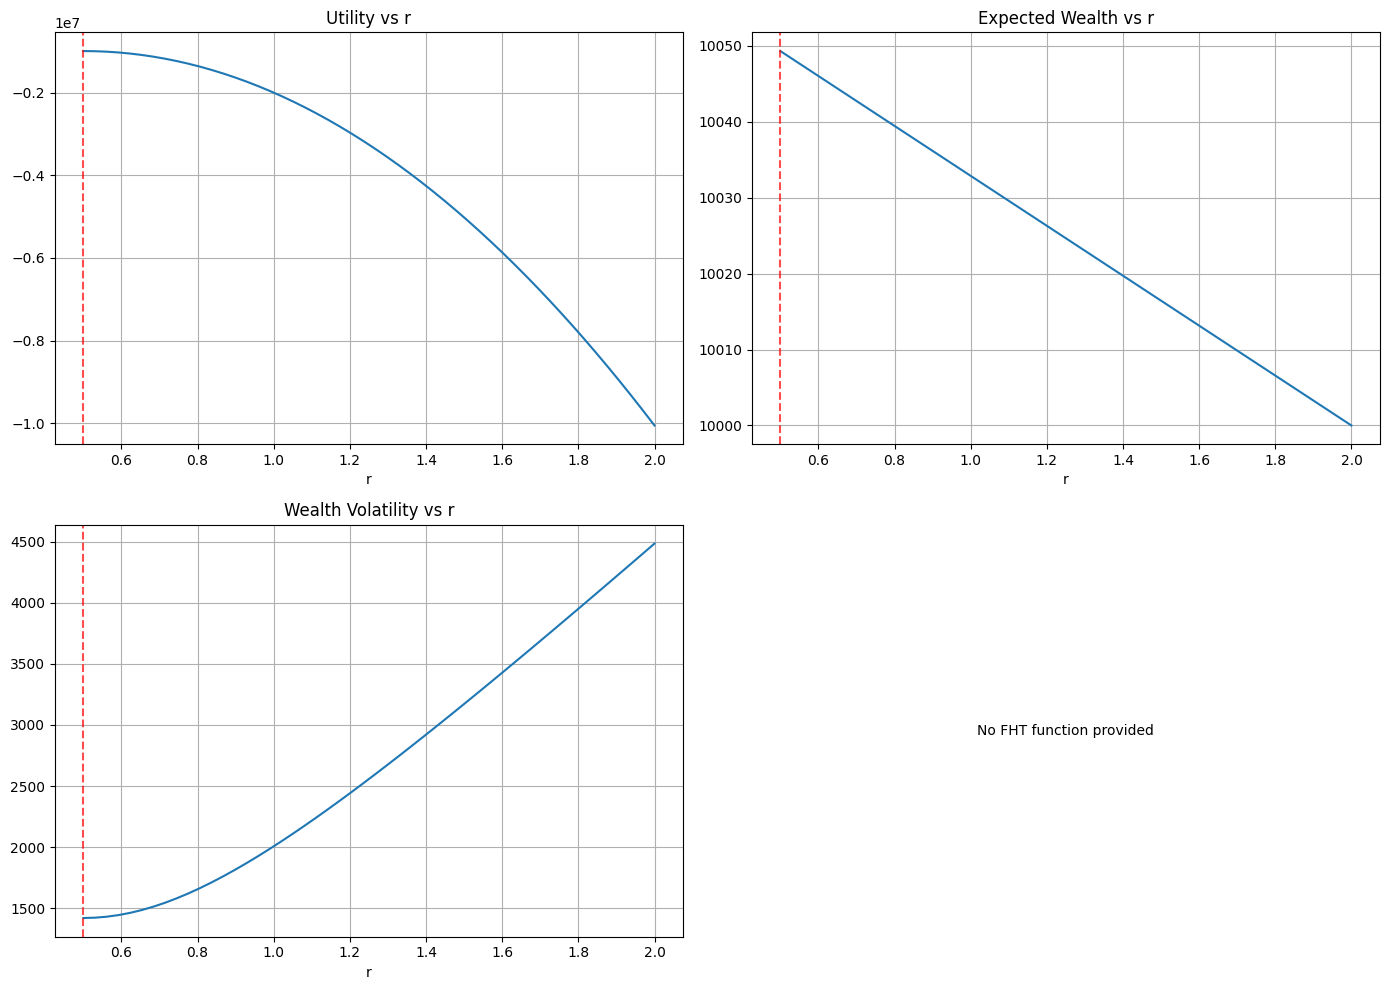

In [17]:
# ----------------------------------------------------
# Scan utility over r & plot
# ----------------------------------------------------

def compute_grid(strategy: StablecoinShortStrategy,
                 r_min: float = 0.5,
                 r_max: float = 2.0,
                 n: int = 50,
                 rho1: float = 0.5,
                 rho2: float = 1.0) -> pd.DataFrame:
    r_vals = np.linspace(r_min, r_max, n)
    rows = []
    for r in r_vals:
        stats = strategy.utility(r, rho1=rho1, rho2=rho2)
        rows.append(stats)
    df = pd.DataFrame(rows)
    return df


df = compute_grid(strategy, 0.5, 2.0, 50, rho1=0.5, rho2=1.0)

# Find optimum
idx = df["U"].idxmax()
opt = df.loc[idx]

print(f"Optimal r*: {opt['r']:.3f}")
print(f"Expected wealth: {opt['meanW']:.2f}")
print(f"Variance: {opt['varW']:.2f}")
print(f"P(liq): {opt['p_liq']}")


# Plot utility, expected wealth, and variance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(df["r"], df["U"], label="Utility")
axes[0, 0].axvline(opt["r"], color="red", linestyle="--", alpha=0.7)
axes[0, 0].set_title("Utility vs r")
axes[0, 0].set_xlabel("r")
axes[0, 0].grid(True)

axes[0, 1].plot(df["r"], df["meanW"], label="E[Wealth]")
axes[0, 1].axvline(opt["r"], color="red", linestyle="--", alpha=0.7)
axes[0, 1].set_title("Expected Wealth vs r")
axes[0, 1].set_xlabel("r")
axes[0, 1].grid(True)

axes[1, 0].plot(df["r"], np.sqrt(df["varW"]), label="Std(Wealth)")
axes[1, 0].axvline(opt["r"], color="red", linestyle="--", alpha=0.7)
axes[1, 0].set_title("Wealth Volatility vs r")
axes[1, 0].set_xlabel("r")
axes[1, 0].grid(True)

if df["p_liq"].notna().any():
    axes[1, 1].plot(df["r"], df["p_liq"], label="P(liq)")
    axes[1, 1].axvline(opt["r"], color="red", linestyle="--", alpha=0.7)
    axes[1, 1].set_title("Liquidation Probability vs r")
    axes[1, 1].set_xlabel("r")
    axes[1, 1].grid(True)
else:
    axes[1, 1].text(0.5, 0.5, "No FHT function provided",
                    ha="center", va="center",
                    transform=axes[1, 1].transAxes)
    axes[1, 1].axis("off")

plt.tight_layout()
plt.show()
